在本例中，我们使用爱彼迎在加拿大多伦多的一份数据，对这份数据我们进行数据的分析和机器学习训练
我们将站在消费者的角度对这份数据进行探索试的分析，尝试找出房租定价和其他因素间的关系

In [1]:
# 导入类库
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

数据字段描述
listing_id  房屋数据编号
date        当前记录时间
available   当前房间是否没被租赁
price       如果没有被租赁，则显示价格

In [2]:
calendar=pd.read_csv(r'data_set\calendar.csv.gz')
print('We have', calendar.date.nunique(), 'days and', calendar.listing_id.nunique(), 'unique listings in the calendar data.')

We have 365 days and 17333 unique listings in the calendar data.


In [3]:
calendar.head()

,listing_id,date,available,price
0,349827,2019-06-17,t,$200.00
1,349827,2019-06-16,t,$200.00
2,349827,2019-06-15,t,$200.00
3,349827,2019-06-14,t,$200.00
4,349827,2019-06-13,t,$200.00


In [4]:
calendar.date.min(), calendar.date.max()

('2018-10-06', '2019-10-05')

In [5]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price         4069436
dtype: int64

In [6]:
calendar.shape

(6326545, 4)

In [7]:
calendar.available.value_counts()

f    4069436
t    2257109
Name: available, dtype: int64

f (false) 代表已经被租用 , t(true) 代表可以被出租

请按天进行汇总，找出数据集每天房屋的入住率

In [8]:
calendar_new=calendar[['date', 'available']]
calendar_new['busy']=calendar_new.available.map(lambda x: 0 if x=='t' else 1)
calendar_new=calendar_new.groupby('date')['busy'].mean().reset_index()
calendar_new['date']=pd.to_datetime(calendar_new['date'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [9]:
calendar_new

,date,busy
0,2018-10-06,0.893383
1,2018-10-07,0.831593
2,2018-10-08,0.773957
3,2018-10-09,0.767496
4,2018-10-10,0.763342
...,...,...
360,2019-10-01,0.708879
361,2019-10-02,0.710725
362,2019-10-03,0.711014
363,2019-10-04,0.712456


C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, '% busy')

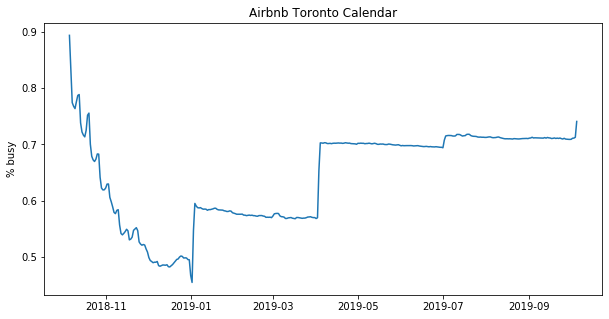

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(calendar_new['date'], calendar_new['busy'])
plt.title('Airbnb Toronto Calendar')
plt.ylabel(r'% busy')

通过图中我们可以看到，10月是最繁忙的，然后是第二年的7-9月，由于这份数据是来自爱彼迎多伦多地区，所以可以推断出整个短租房的入住率是在下半年会比较旺盛。

### 接下来我们来观察一年当中价格的走势变化

此次有两个分析技巧，由于价格部分带有$符号和,号，所以我们需要对数据进行格式化处理，并且转换时间字段。处理完时间字段后，我们使用柱状图进行数据分析

In [11]:
calendar['date']=pd.to_datetime(calendar['date'])
calendar['price']=calendar['price'].str.replace(',', '')
calendar['price']=calendar['price'].str.replace('$', '')
calendar['price']=calendar['price'].astype(float)

Text(0.5, 0, 'average monthly price')

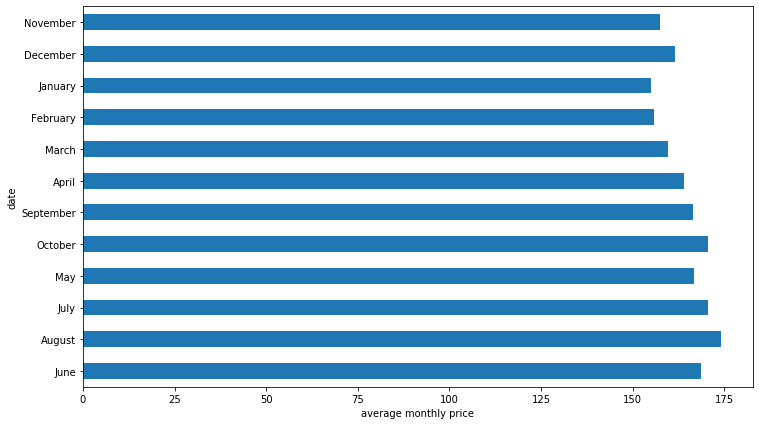

In [12]:
mean_of_month=calendar.groupby(calendar['date'].dt.strftime('%B'),
                              sort=False)['price'].mean()
mean_of_month.plot(kind='barh', figsize=(12, 7))
plt.xlabel('average monthly price')

图中可以看出7月 8月和10月是平均价格最高的三个月。

然后我们把时间跨度改为每天，看看在一周内七天，这些短租房的价格走势如何

([<matplotlib.axis.XTick at 0x1d3d0e5b448>,
 <a list of 7 Text xticklabel objects>)

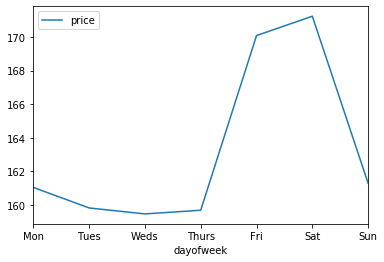

In [13]:
calendar['dayofweek']=calendar.date.dt.weekday_name
cats=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
price_week=calendar[['dayofweek', 'price']]
price_week=calendar.groupby(['dayofweek']).mean().reindex(cats)
price_week.drop('listing_id', axis=1, inplace=True)
price_week.plot()
ticks=list(range(7))
labels='Mon Tues Weds Thurs Fri Sat Sun'.split()
plt.xticks(ticks, labels)

和我们预料的非常类似，短租房本身大都为了旅游而存在，所以周五周六两天的价格都比其他时间贵出一个档次。（周末双休，使得入驻的时间为周五周六晚两个晚上）

### 房屋信息

#### listing这个数据文件用来放置所有在爱彼迎平台上登记的短租房信息

In [14]:
listings=pd.read_csv(r'data_set\listings.csv.gz')
print('We have', listings.id.nunique(), 'listings in the listing data.')

We have 17343 listings in the listing data.


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (88) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [16]:
listings.shape

(17343, 96)

In [17]:
listings.groupby(by='neighbourhood_cleansed').count()[['id']].sort_values(by='id', ascending=False).head(10)

,id
neighbourhood_cleansed,
Waterfront Communities-The Island,3181
Niagara,807
Annex,711
Church-Yonge Corridor,592
Dovercourt-Wallace Emerson-Junction,517
Little Portugal,504
Bay Street Corridor,497
Trinity-Bellwoods,459
Kensington-Chinatown,449


### 每一套住房都有入住评价，我们来观察一下房子的评分情况

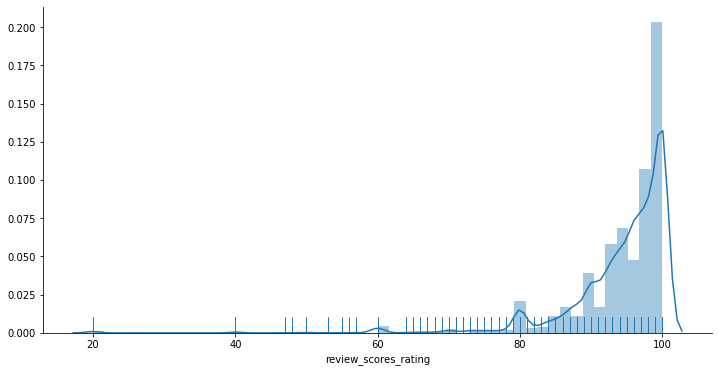

In [18]:
plt.figure(figsize=(12, 6))
sns.distplot(listings.review_scores_rating.dropna(), rug=True)
sns.despine()

此处的评分标准为0-100分制，通过上述表格可以看出总体来看爱彼迎的房屋好评率非常高。

### 接下来我们分析价格部分

In [19]:
listings['price']=listings['price'].str.replace(',', '')
listings['price']=listings['price'].str.replace('$', '')
listings['price']=listings['price'].astype(float)

In [20]:
listings['price'].describe()

count    17343.000000
mean       144.363259
std        245.723788
min          0.000000
25%         65.000000
50%        100.000000
75%        166.000000
max      12933.000000
Name: price, dtype: float64

多伦多最昂贵的Airbnb房源价格为$ 12933 /晚,以下是房屋的链接 https://www.airbnb.ca/rooms/16039481?locale=en. 通过链接可以发现之所以比平均价贵出约100倍，主要是因为这处房屋是多伦多最时尚的社区中的艺术收藏家阁楼。（这些艺术收藏的价值大幅的拉高了这处房源的价格，使其和平均值有100倍的差距）

In [23]:
listings.iloc[np.argmax(listings['price'])]

id                                                               16039481
listing_url                         https://www.airbnb.com/rooms/16039481
scrape_id                                                  20181006000710
last_scraped                                                   2018-10-06
name                                            Art Collector's Penthouse
                                                    ...                  
cancellation_policy                                              flexible
require_guest_profile_picture                                           f
require_guest_phone_verification                                        f
calculated_host_listings_count                                          1
reviews_per_month                                                     NaN
Name: 6940, Length: 96, dtype: object

由于在数据分析中，我们需要服从正态分布的原则，对于这样极端情况的存在，我们需要进行清理，所以我们把超过600元价格的数据进行过滤

In [25]:
listings[listings['price']>600]['price'].describe()

count      205.000000
mean      1361.746341
std       1687.211496
min        603.000000
25%        740.000000
50%        850.000000
75%       1200.000000
max      12933.000000
Name: price, dtype: float64

In [26]:
listings[listings['price']==0]['price'].count()

7

#### 去掉极端值后我们继续观察现在的价格分布状态

Text(0.5, 1.0, 'Histogram of listing prices')

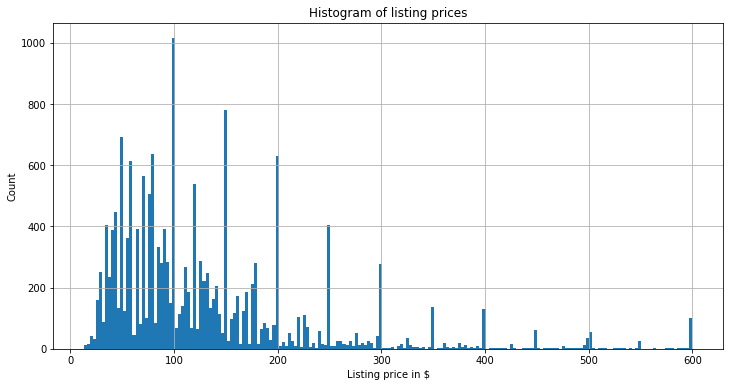

In [28]:
plt.figure(figsize=(12, 6))
listings[(listings.price<=600) & (listings.price>0)].price.hist(bins=200)
plt.ylabel('Count')
plt.xlabel('Listing price in $')
plt.title('Histogram of listing prices')

#### Neighbourhood vs. Price  对社区和价格的关联度进行分析

[Text(0, 0, 'Waterfront Communities-The Island'),
 Text(0, 0, 'Niagara'),
 Text(0, 0, 'Rosedale-Moore Park'),
 Text(0, 0, 'Bay Street Corridor'),
 Text(0, 0, 'Yonge-St.Clair'),
 Text(0, 0, 'Yonge-Eglinton'),
 Text(0, 0, 'Annex'),
 Text(0, 0, 'Church-Yonge Corridor'),
 Text(0, 0, 'Moss Park'),
 Text(0, 0, 'Lawrence Park South'),
 Text(0, 0, 'The Beaches'),
 Text(0, 0, 'Yorkdale-Glen Park'),
 Text(0, 0, 'South Riverdale'),
 Text(0, 0, 'Trinity-Bellwoods'),
 Text(0, 0, 'Kingsway South'),
 Text(0, 0, 'Mount Pleasant West'),
 Text(0, 0, 'Casa Loma'),
 Text(0, 0, 'Lawrence Park North'),
 Text(0, 0, 'Mimico (includes Humber Bay Shores)'),
 Text(0, 0, 'Little Portugal'),
 Text(0, 0, 'Leaside-Bennington'),
 Text(0, 0, 'Bridle Path-Sunnybrook-York Mills'),
 Text(0, 0, 'Bedford Park-Nortown'),
 Text(0, 0, 'Lansing-Westgate'),
 Text(0, 0, 'Kensington-Chinatown'),
 Text(0, 0, 'Cabbagetown-South St.James Town'),
 Text(0, 0, 'Woodbine Corridor'),
 Text(0, 0, 'South Parkdale'),
 Text(0, 0, 'Regent Par

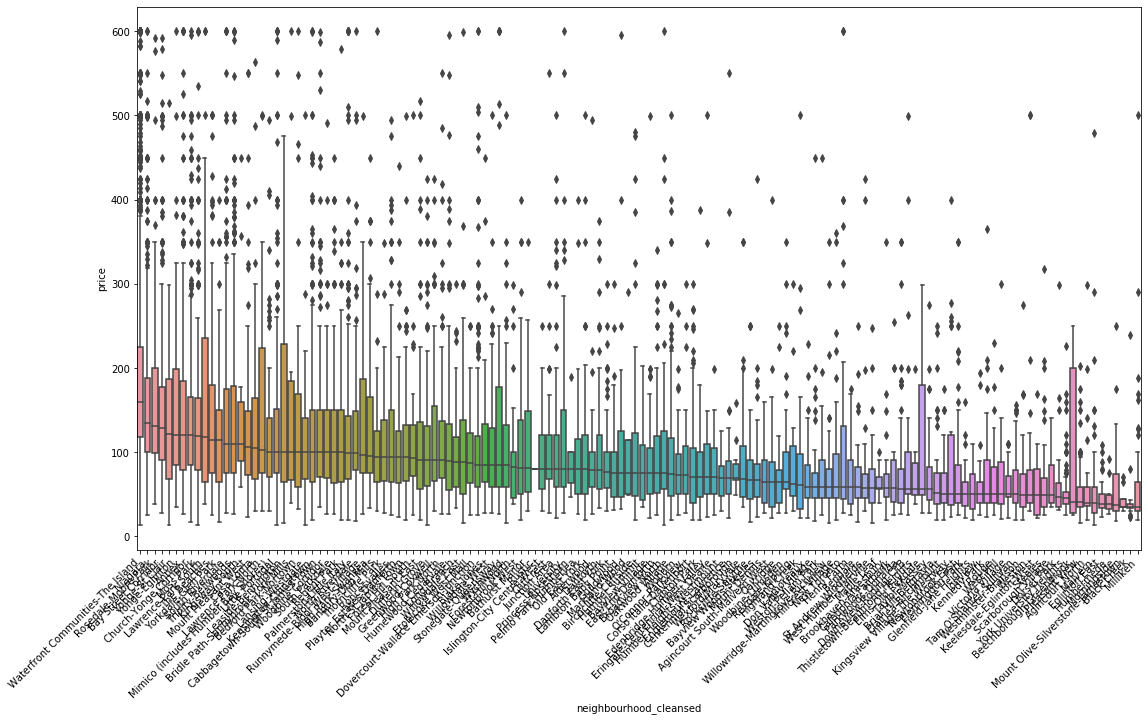

In [31]:
plt.figure(figsize=(18, 10))
sort_price=listings[(listings.price<=600)&(listings.price>0)].groupby('neighbourhood_cleansed')['price'].median().sort_values(ascending=False).index
sns.boxplot(y='price', x='neighbourhood_cleansed', data=listings[(listings.price<=600)&(listings.price>0)], order=sort_price)
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

利用boxplot我们观察到，最好的社区不仅房源的最高价高，而且平均价格也是所有社区中最高的，很有代表性。
箱线之外的点，代表离群值，是超过3个标准差之外的值

#### host vs. price  接下来我们来观察Superhost 这个信息，带有这个标记的房产为高级房，需要满足一定的评级要求，比如100次以上成功的预定，好评率超过90%等。我们看带有这个评级的房屋与不具备这个标记的房屋在价格上是否有差别

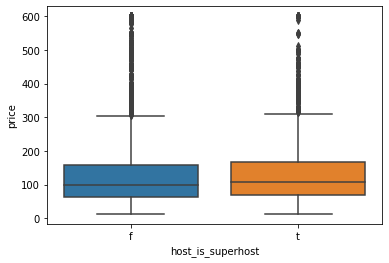

In [32]:
sns.boxplot(y='price', x='host_is_superhost', data=listings[(listings.price<=600)&(listings.price>0)])

通过分析可以看出，高级房的价格是会略微高于普通房。

#### property type vs. price 房屋的软装特性和价格的关系

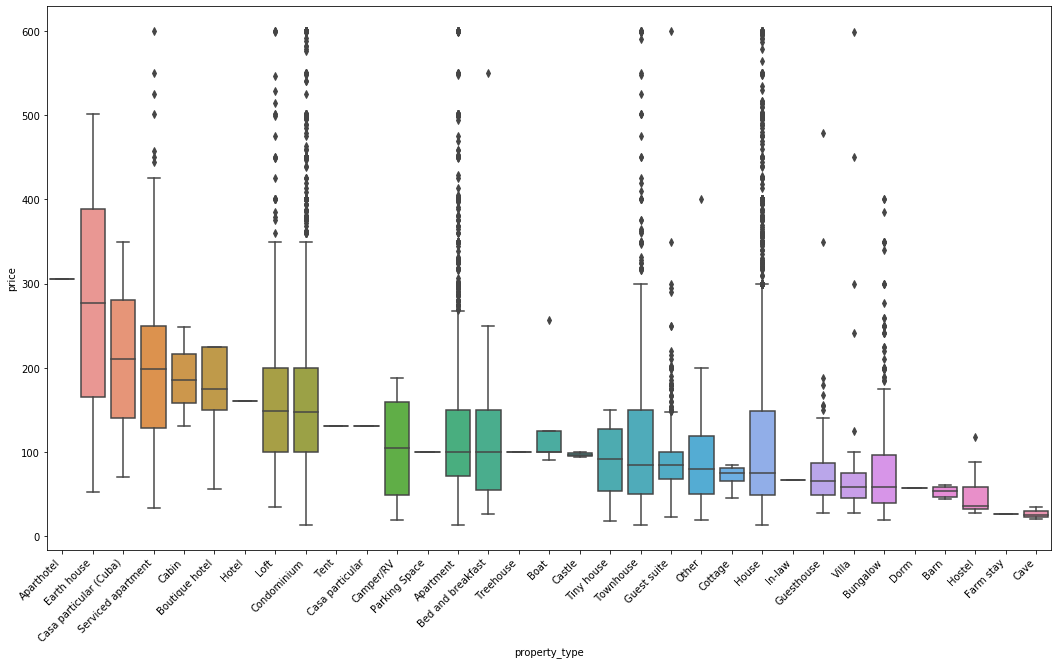

In [34]:
plt.figure(figsize=(18, 10))
sort_price=listings[(listings.price<=600)&(listings.price>0)].groupby('property_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y='price', x='property_type', data=listings[(listings.price<=600)&(listings.price>0)], order=sort_price)
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

从这个图中可以看到在数据处理时，如果对于极端值不进行处理，则会显示出这样怪异的情况，例如Aparthotel
公寓式酒店 这个关键词的价格最高，但是通过boxplot我们又可以看出，其实只有一套这样的房产，所以数据并不完整。tend（帐篷）和parking space （停车位）这样的关键词也是数量很少的，导致了数据结果显示不准确。

In [35]:
listings.property_type.value_counts()

Apartment                 5810
House                     4611
Condominium               4019
Townhouse                  836
Guest suite                581
Bungalow                   462
Loft                       434
Serviced apartment         195
Bed and breakfast           95
Guesthouse                  92
Other                       59
Villa                       56
Boutique hotel              26
Hostel                      21
Barn                         6
Boat                         5
Cottage                      5
Camper/RV                    4
Tiny house                   4
Cabin                        3
Cave                         3
Casa particular (Cuba)       2
Earth house                  2
Farm stay                    2
Castle                       2
Casa particular              1
In-law                       1
Parking Space                1
Dorm                         1
Hotel                        1
Aparthotel                   1
Tent                         1
Treehous

#### room type vs. price  房型和价格的关系

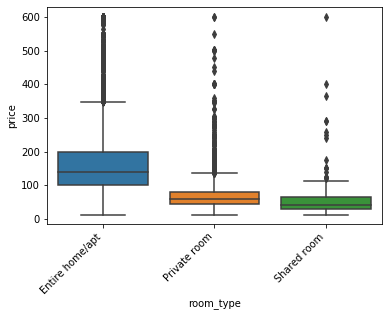

In [40]:
sort_price=listings[(listings.price<=600)&(listings.price>0)].groupby('room_type')['price'].median().sort_values(ascending=False).index
sns.boxplot(y='price', x='room_type', data=listings[(listings.price<=600)&(listings.price>0)], order=sort_price)
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

租整套的价格明显比多人合租要贵

Text(0.5, 0, 'listing price in $')

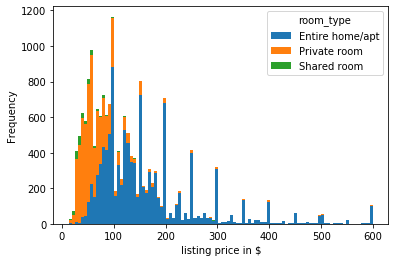

In [42]:
listings[(listings.price<=600)&(listings.price>0)].pivot(columns='room_type', values='price').plot.hist(stacked=True, bins=100)
plt.xlabel('listing price in $')

房屋的便利设施

In [45]:
listings['amenities'].head()

0    {TV,Internet,Wifi,"Air conditioning",Kitchen,"...
1    {TV,"Cable TV",Internet,Wifi,"Air conditioning...
2    {Wifi,"Air conditioning",Kitchen,"Free parking...
3    {Internet,Wifi,"Pets live on this property",Ca...
4    {Internet,Wifi,"Air conditioning",Kitchen,"Fre...
Name: amenities, dtype: object

In [49]:
listings.amenities=listings.amenities.str.replace('[{}]', '').str.replace('"', '')

In [50]:
listings.amenities

0        TV,Internet,Wifi,Air conditioning,Kitchen,Indo...
1        TV,Cable TV,Internet,Wifi,Air conditioning,Poo...
2        Wifi,Air conditioning,Kitchen,Free parking on ...
3        Internet,Wifi,Pets live on this property,Cat(s...
4        Internet,Wifi,Air conditioning,Kitchen,Free pa...
                               ...                        
17338    TV,Wifi,Kitchen,Gym,Heating,Washer,Dryer,Smoke...
17339    TV,Cable TV,Internet,Wifi,Air conditioning,Poo...
17340    Wifi,Air conditioning,Kitchen,Heating,Suitable...
17341    TV,Wifi,Air conditioning,Kitchen,Gym,Elevator,...
17342    TV,Air conditioning,Kitchen,Gym,Elevator,Heati...
Name: amenities, Length: 17343, dtype: object

找出前20个最重要的便利设施

[Text(0, 0, 'Wifi'),
 Text(0, 0, 'Heating'),
 Text(0, 0, 'Essentials'),
 Text(0, 0, 'Kitchen'),
 Text(0, 0, 'Smoke detector'),
 Text(0, 0, 'Air conditioning'),
 Text(0, 0, 'Hangers'),
 Text(0, 0, 'Washer'),
 Text(0, 0, 'Dryer'),
 Text(0, 0, 'Shampoo'),
 Text(0, 0, 'Carbon monoxide detector'),
 Text(0, 0, 'Laptop friendly workspace'),
 Text(0, 0, 'TV'),
 Text(0, 0, 'Hair dryer'),
 Text(0, 0, 'Iron'),
 Text(0, 0, 'Hot water'),
 Text(0, 0, 'Fire extinguisher'),
 Text(0, 0, 'Elevator'),
 Text(0, 0, 'Family/kid friendly'),
 Text(0, 0, 'Free parking on premises')]

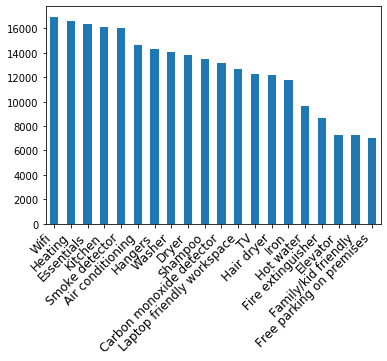

In [53]:
pd.Series(np.concatenate(listings['amenities'].map(lambda X: X.split(',')))).value_counts().head(20).plot(kind='bar')
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=12)

Wifi 暖气 厨房等便利设施是最重要的部分

#### 接下来看一下前20的便利设施和价格间的关系